## Import Required Libraries

In [2]:
import numpy as np
import json
import glob
import re

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaModel

#spacy
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

#vis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt 
import pandas as pd

#nltk.download(punkt)
#nltk.download(wordnet) 

C:\Program Files\Python310\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


### Data Input 

In [5]:
def load_data(file):
    with open (file, "r", encoding="utf-8") as f:
        data = json.load(f) 
    return (data)

def write_data(file, data):
    with open (file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)
stories = load_data("local_data.json")["File"]
print(stories[0][:100])


My mum had me at 15 years. No idea who my dad is. I grew up with a single mum who would spend every 


### Pre-process and vectorize the documents 

In [6]:
#In case prompted to install stopwords, use "nltk.download(stopwords)".
#Lemmatization
stops = set(stopwords.words("english"))

def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    #Use "python -m spacy download en_core_web_sm" if error [E050]
    #only the parts of speech tagger neede, the parser and ner don't produce better results and are slower to implement 
    nlp = spacy.load("en_core_web_sm",disable=["parser","ner"]) 
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
        
    return(texts_out)

lemmatized_texts = lemmatization(stories)
print(lemmatized_texts[0][:100])

C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entr

C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entr

mum year idea dad grow single mum spend last dollar coke say poor understatement amount government a


In [7]:
#deaccenting, removing stop words and 
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True, min_len=3)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)
print (data_words[0][0:20])

['mum', 'year', 'idea', 'dad', 'grow', 'single', 'mum', 'spend', 'last', 'dollar', 'coke', 'say', 'poor', 'understatement', 'amount', 'government', 'assistance', 'get', 'mother', 'addict']


In [8]:
#BIGRAMS AND TRIGRAMS
#Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels
bigram_phrases = gensim.models.Phrases(data_words, min_count=2,threshold=10)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words],threshold=2)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return(bigram[doc] for doc in texts)

def make_trigrams(texts): 
    return(trigram[bigram[doc]] for doc in texts)

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

data_bigrams_trigrams = list(data_bigrams_trigrams)
print(data_bigrams_trigrams[0])

['mum', 'year', 'idea', 'dad', 'grow', 'single', 'mum', 'spend', 'last', 'dollar', 'coke', 'say', 'poor', 'understatement', 'amount', 'government', 'assistance', 'get', 'mother', 'addict', 'move', 'around', 'lot', 'different', 'school', 'grow', 'have', 'food', 'common', 'occurrence', 'homeless', 'period', 'time', 'kid', 'wash', 'public', 'restroom', 'time', 'time', 'send', 'other', 'relative', 'live', 'sexually', 'abuse', 'multiple', 'occasion', 'keep', 'year', 'kid', 'terrifying', 'speak', 'already', 'live', 'shaky', 'unstable', 'world', 'uproot', 'last', 'foundation', 'even', 'drug', 'addle', 'mother', 'unthinkable', 'anyway', 'fast', 'forward', 'try', 'really_hard', 'school', 'mean', 'really_hard', 'only', 'way', 'see', 'get', 'hole', 'mum', 'drop', 'school', 'know', 'never', 'want', 'end', 'get', 'job', 'day', 'birthday', 'country', 'legal', 'age', 'start', 'work', 'day', 'year', 'now', 'spend', 'day', 'unemployed', 'work', 'save', 'much', 'mum', 'tell', 'move', 'again', 'say', 'mo

In [9]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel
 
id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams
# print(texts[0][:20])

corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

### Training LDA Model 

In [51]:
# Set training parameters.
num_topics = 10
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1  

lda_model = LdaModel(
    corpus=corpus, 
    id2word=id2word,
    chunksize=chunksize,
    alpha="auto",
    eta="auto",
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
#lda_model.save("Models/test_model_1.model")

### Top topics detected by model (visualize for clusters)

In [ ]:
# top_topics = lda_model.top_topics(corpus)

# # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
# avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
# print(f'Average topic coherence: %.4f. % avg_topic_coherence')

# from pprint import pprint
# print(top_topics)

### Saving/loading the LDA Model (just experimental)

In [3]:
new_model = gensim.models.ldamodel.LdaModel.load("Models/test_model_1.model")

# Visualization and Tabulization

In [27]:
#use "pip install pyLDAvis" if the pyLDAvis library isn't installed on your system
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(new_model, corpus, id2word, mds="mmds", R=30)
vis

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.

In [10]:
#Computte Coherence Score 
coherence_model_lda = CoherenceModel(
    model = new_model,
    texts = texts, 
    dictionary = id2word, 
    coherence = 'c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.43906016417318644


### Tuning LDA Model

In [16]:
#Using a function to find the most optimal number of topics for a better coherence score. 
"""Source_1 = https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know"""
"""Source_2 = https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel"""

def compute_coherence_values(chunksize, passes, iterations, eval_every, dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
 
 -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(
        corpus=corpus, 
        id2word=id2word,
        chunksize=chunksize,
        alpha="auto",
        eta="auto",
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=corpus, 
    texts=texts, 
    start=2, 
    limit=40, 
    step=4, 
    chunksize = 2000, 
    passes = 20, 
    iterations = 400,
    eval_every = 1
)

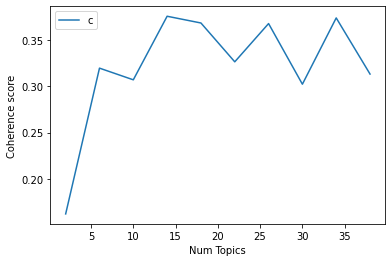

In [21]:
# Show graph
import matplotlib.pyplot as plt 
import pandas as pd

limit=40; start=2; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
#Extracting the topic that gives the best results. 
best_result_model = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_model]
print(f'''{x[best_result_model]} topics give the highest coherence score of {coherence_values[best_result_model]} for this specific model''')

14 topics give the highest coherence score of 0.37607379013282405 for this specific model


In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\MoRevolution\AppData\Roaming\Python\Python310\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.120326  0.160740       1        1  25.799658
3      0.092122 -0.184126       2        1  25.286595
7      0.088493  0.188564       3        1  17.376522
5     -0.156370 -0.144909       4        1  14.825302
2     -0.110737  0.041788       5        1   5.594182
8      0.094236  0.062627       6        1   4.872833
0      0.128945 -0.035917       7        1   3.731188
4     -0.043133 -0.055348       8        1   2.491054
6      0.013441 -0.016646       9        1   0.011592
1      0.013329 -0.016775      10        1   0.011073, topic_info=             Term       Freq      Total Category  logprob  loglift
124          work  19.000000  19.000000  Default  30.0000  30.0000
57            job  17.000000  17.000000  Default  29.0000  29.0000
140          good   9.000000   9.000000  Default  28.0000  28.0000
168          well  12.000000  12.000000  Default  27.0000  27.0000
41            get  15.000000  15.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
25      different   0.000238   1.868198  Topic10  -6.7776   0.1412
26         dollar   0.000238   2.117710  Topic10  -6.7776   0.0158
27           drop   0.000238   3.836879  Topic10  -6.7776  -0.5785
28           drug   0.000238   3.751834  Topic10  -6.7776  -0.5561
29   emancipation   0.000238   1.356262  Topic10  -6.7776   0.4614

[562 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
127       2  0.189567        able
127       3  0.568701        able
127       4  0.189567        able
815       2  0.738487  absolutely
0         1  0.737321       abuse
...     ...       ...         ...
126       1  0.472202        year
126       2  0.404745        year
126       5  0.134915        year
466       6  0.978612       yield
620       4  0.983845       young

[579 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 8, 6, 3, 9, 1, 5, 7, 2])

In [29]:
# optimal_model.save("Models/Model V2/test_model_2.model")

In [41]:
results = optimal_model[corpus]
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in results]
print(corpus_topics)

[(9, 0.99878013), (7, 0.8844808), (7, 0.9980773), (2, 0.9977718), (9, 0.99819404), (7, 0.9986689), (4, 0.9952469), (8, 0.9975605), (0, 0.8668096), (5, 0.9991976), (9, 0.99753314), (3, 0.99908435), (9, 0.9984991), (3, 0.9976406), (3, 0.9977699), (3, 0.9974322)]


In [58]:
topics = [[(term, round(wt, 3)) for term, wt in optimal_model.show_topic(n, topn=20)] for n in range(0, optimal_model.num_topics)]
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, optimal_model.num_topics+1)] )


C:\Users\MoRevolution\AppData\Local\Temp\ipykernel_27976\4272295173.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"good, family, sister, back, big, relative, then, friend, try, poor, so, city, away, attitude, wear, nearly, wealthy, hang, always, embarrassed"
Topic2,"schedule, steal, stretch, someday, spelling, scrape, realize, salary, retirement, retire, rest, respect, requisite, rent, remember, relentless, refuse, sea, stay, ready"
Topic3,"job, well, school, graduate, get, year, first, college, work, together, keep, side, grow, law, family, other, good, take, always, come"
Topic4,"feel, student, year, school, well, also, lot, push, struggle, bachelor, help, come, always, graduate, high_school, mom, first, college, only, grow"
Topic5,"work, hard, school, good, full, thing, help, parent, see, encourage, finish, upper_middle, employee, garage, extremely, sale, minimum, wage, expensive, teacher"
Topic6,"work, people, school, take, think, friend, good, adopt, parent, say, undergrad, thing, kid, free, one, grant, still, last, life, meal"
Topic7,"school, feel, make, connect, student, only, other, never, friend, hard, first, bad, white, person, especially, situation, tool, mental, as, positive"
Topic8,"job, get, work, college, class, most, need, able, community, career, big, more, way, it, experience, bachelor, take, lose, surprise, soon"
Topic9,"school, live, result, own, actually, level, home, high_school, point, extreme, focus, form, combine, basically, idea, bath, parent, move, competition, book"
Topic10,"go, get, year, just, lot, so, school, work, live, start, even, know, kid, grow, day, time, never, mum, move, keep"


In [62]:
# for i in range(10): 
#     outF = open('Word Net and Concept Net/Topics_Model V2/Topic' + str(i+1)+'.txt', 'w')
#     print(topics_df['Terms per Topic'][i], file = outF)

IndexError: index 10 is out of bounds for axis 0 with size 10